In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from models import CNNClassifier
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [2]:
Q = 6
nconf = 81
ndata = 200
L = 64
T_cr_1 = 0.701 # critical temp for 2d clock
T_cr_2 = 0.898 # critical temp for 2d clock
t_start = 0.4

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Clock", q=Q)
# print(prm_list)
print(f"データ数:{nconf*ndata}")

[[0.4, '../dataset/2d_Clock/L64_q=6/L64T0_'], [0.41, '../dataset/2d_Clock/L64_q=6/L64T1_'], [0.42, '../dataset/2d_Clock/L64_q=6/L64T2_'], [0.43, '../dataset/2d_Clock/L64_q=6/L64T3_'], [0.44, '../dataset/2d_Clock/L64_q=6/L64T4_'], [0.45, '../dataset/2d_Clock/L64_q=6/L64T5_'], [0.46, '../dataset/2d_Clock/L64_q=6/L64T6_'], [0.47, '../dataset/2d_Clock/L64_q=6/L64T7_'], [0.48, '../dataset/2d_Clock/L64_q=6/L64T8_'], [0.49, '../dataset/2d_Clock/L64_q=6/L64T9_'], [0.5, '../dataset/2d_Clock/L64_q=6/L64T10_'], [0.51, '../dataset/2d_Clock/L64_q=6/L64T11_'], [0.52, '../dataset/2d_Clock/L64_q=6/L64T12_'], [0.53, '../dataset/2d_Clock/L64_q=6/L64T13_'], [0.54, '../dataset/2d_Clock/L64_q=6/L64T14_'], [0.55, '../dataset/2d_Clock/L64_q=6/L64T15_'], [0.56, '../dataset/2d_Clock/L64_q=6/L64T16_'], [0.57, '../dataset/2d_Clock/L64_q=6/L64T17_'], [0.58, '../dataset/2d_Clock/L64_q=6/L64T18_'], [0.59, '../dataset/2d_Clock/L64_q=6/L64T19_'], [0.6, '../dataset/2d_Clock/L64_q=6/L64T20_'], [0.61, '../dataset/2d_Clo

temperature:0.49


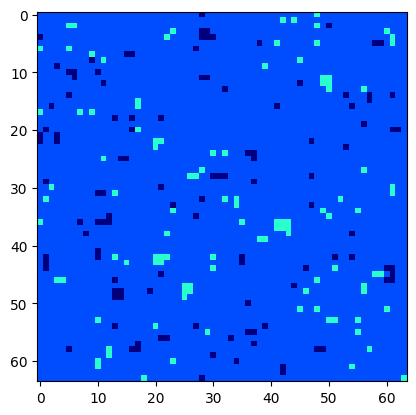

temperature:0.61


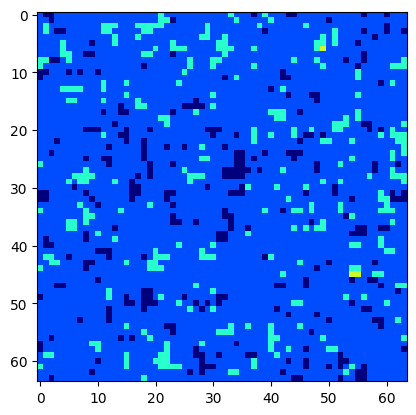

temperature:0.78


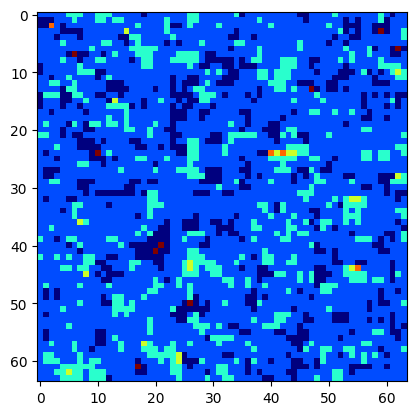

temperature:0.82


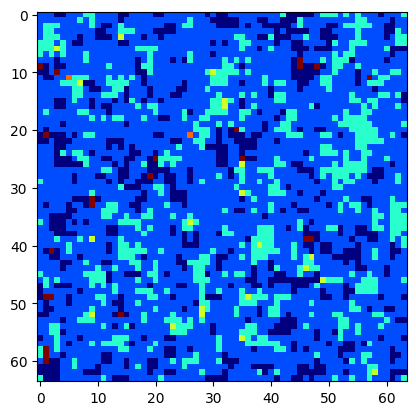

temperature:0.98


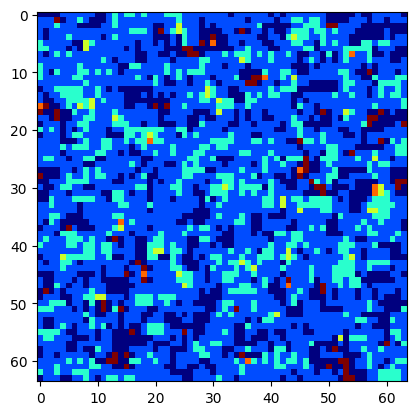

temperature:1.19


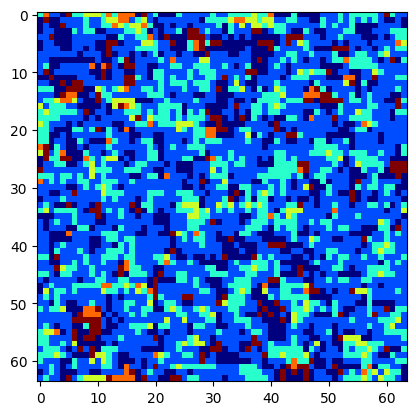

In [3]:
# 可視化
for num in [9, 21, 38, 42, 58, 79]:
    for iconf in range(1):
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        print(f"temperature:{prm_list[num][0]}")
        plt.imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')
    plt.show()

In [4]:
dataset, _ = create_train_data_CV(prm_list=prm_list, ndata=ndata, T_cr_1=T_cr_1, T_cr_2=T_cr_2, exclude_T=(0.65, 0.76, 0.84, 0.95), total_label=3)
print("dataset.shape = ", len(dataset))

dataset.shape =  11400


mps is available.
FOLD 1
--------------------------------
Epoch: 10, Validation loss: 0.00019319897007989584, Accuracy: 99.82456140350877%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1012
           1     0.9904    0.9968    0.9936       312
           2     0.9990    0.9969    0.9979       956

    accuracy                         0.9982      2280
   macro avg     0.9965    0.9979    0.9972      2280
weighted avg     0.9983    0.9982    0.9982      2280



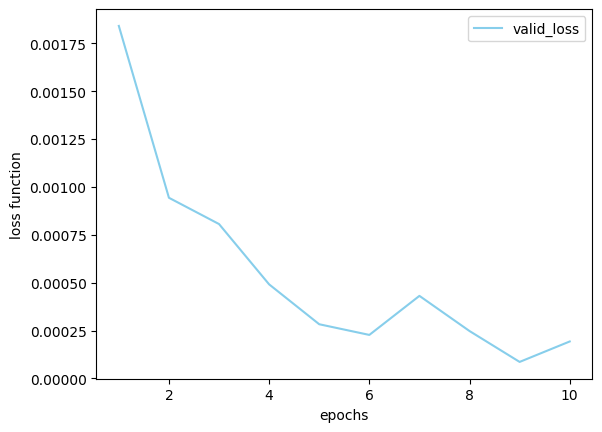

FOLD 2
--------------------------------
Epoch: 10, Validation loss: 3.02602935345488e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       992
           1     1.0000    1.0000    1.0000       278
           2     1.0000    1.0000    1.0000      1010

    accuracy                         1.0000      2280
   macro avg     1.0000    1.0000    1.0000      2280
weighted avg     1.0000    1.0000    1.0000      2280



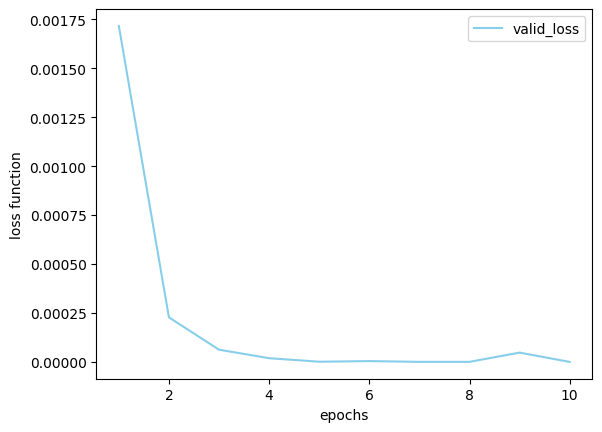

FOLD 3
--------------------------------
Epoch: 10, Validation loss: 0.0005439261610586312, Accuracy: 99.3859649122807%
Classification Report:
               precision    recall  f1-score   support

           0     0.9980    1.0000    0.9990      1003
           1     0.9648    0.9856    0.9751       278
           2     0.9980    0.9900    0.9940       999

    accuracy                         0.9939      2280
   macro avg     0.9869    0.9919    0.9894      2280
weighted avg     0.9939    0.9939    0.9939      2280



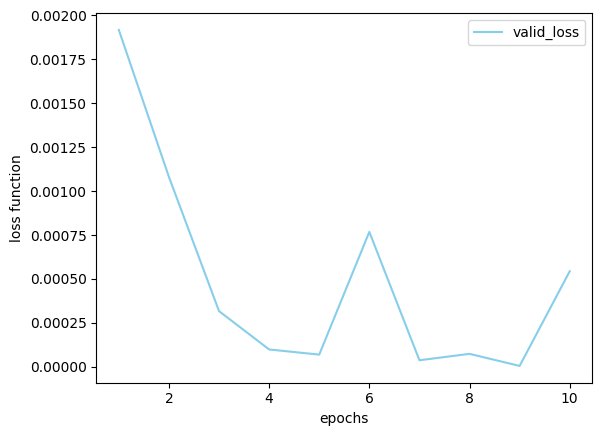

FOLD 4
--------------------------------
Epoch: 10, Validation loss: 3.8518438694218433e-07, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1011
           1     1.0000    1.0000    1.0000       268
           2     1.0000    1.0000    1.0000      1001

    accuracy                         1.0000      2280
   macro avg     1.0000    1.0000    1.0000      2280
weighted avg     1.0000    1.0000    1.0000      2280



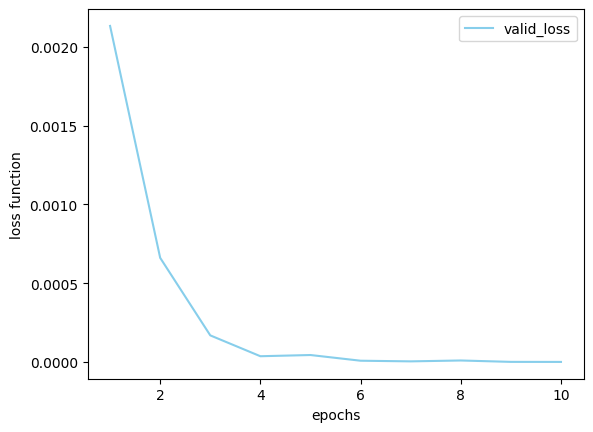

FOLD 5
--------------------------------
Epoch: 10, Validation loss: 4.6932254076346236e-05, Accuracy: 99.95614035087719%
Classification Report:
               precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995       982
           1     1.0000    0.9962    0.9981       264
           2     1.0000    1.0000    1.0000      1034

    accuracy                         0.9996      2280
   macro avg     0.9997    0.9987    0.9992      2280
weighted avg     0.9996    0.9996    0.9996      2280



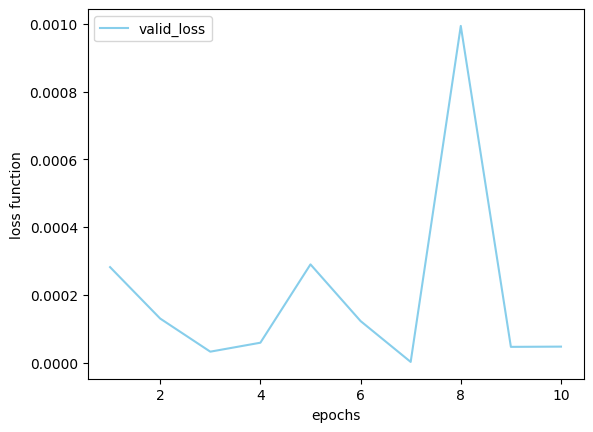

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
Done.


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
target_size = 3
grad_clip = 0.1
norm_type = 2
epochs = 10
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    # weights = torch.tensor([1.0, 5.0, 1.0]).to(device)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs-1:
            print(
                f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(
            answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list,
             label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")
# torch.save(model, "2d_Clock_q=6_model_classifier.pth")

In [ ]:
_, test_dataset = create_train_data_hold_out(prm_list=prm_list, ndata=ndata, T_cr_1=T_cr_1, T_cr_2=T_cr_2, exclude_T=(0.65, 0.76, 0.84, 0.95), total_label=3)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

xs, y1s, y2s, y3s, temps = [], [], [], [], []
prediction = []
sum_pred = 0
count = 0

model.eval()
for data, temp, target in test_loader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction += list(pred.cpu().numpy())
    temps += list(temp.cpu().numpy())
# print(len(prediction), len(temps))

for i in range(len(test_dataset)):
    if i == 0:
        sum_pred += prediction[i]
        count += 1
        xs.append(temps[i])
    else:
        if temps[i] != temps[i-1]:
            # y1s, y2sに格納
            # prob = sum_pred/count
            # y1s.append(1 - prob)
            # y2s.append(prob)
            # y3s.append(prob)

            sum_pred = 0
            count = 0
            sum_pred += prediction[i]
            count += 1
            xs.append(temps[i])
        elif i == len(test_dataset)-1:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)
            y3s.append(prob)
        else:
            sum_pred += prediction[i]
            count += 1
# print(len(xs), len(y1s), len(y2s), len(y3s))

plt.axvline(x=T_cr_1, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr_1))
plt.axvline(x=T_cr_2, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr_2))
plt.xlim(t_start,t_end)
plt.plot(xs, y1s, label=r"$para$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$BKT$", marker="o", color="green")
plt.plot(xs, y3s, label=r"$ferro$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()